In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
np.set_printoptions(precision=2)

In [13]:
def getCalibrationInfo(file):
    calibration = pd.read_csv(file, skiprows=20, names=['PitotVel', 'HotWireEv'])
    PitotVel = np.array(calibration['PitotVel'])
    Voltage = np.array(calibration['HotWireEv'])
    file_coeff = pd.read_csv('calibration_curve', skiprows=15, nrows=1)
    fixed_coeff = np.flip(np.array(file_coeff).reshape((5,)))
    return PitotVel, Voltage, fixed_coeff

def getVelocityProfile(file):
    return pd.read_csv(file, skiprows=16, names=['LateralPos', 'PitotVel', 'PitotVelStd', 'HotWireVel', 'HotWireVelStd'])

def computeInfo(frame, series):
    U = np.mean([frame[series][:3], frame[series][-3:]])
    y_0 = frame.loc[frame[series].idxmin(), 'LateralPos']
    Y = (frame['LateralPos'] - y_0) / 120
    return U, Y

def getTransient(file):
    return np.array(pd.read_excel(file, header=None, skiprows=1, engine='openpyxl'))

def computeFFT(file):
    data = getTransient(file).flatten('F')
    sp = np.fft.fft(data)
    freq = np.fft.fftfreq(len(data), 1/8000)
    domain = np.nonzero(freq > 0.)
    peak = freq[np.argmax(sp[domain])]
    return sp, freq, peak

def computeDynViscosity(T):
    """
    Returns dynamic viscosity determined by Sutherland's law
    """
    mu_ref = 1.716e-5
    T_ref = 273.15
    S = 110.4
    return mu_ref*(T/T_ref)**1.5*(T_ref + S)/(T + S)

def computeDragDiscrete(U, u, ax, rho, w):
    """
    Returns the drag force using momentum deficit method. 
    The integral is computed using a discrete method.
    """
    dy = ax[1:] - ax[0:-1]
    integrand = u * (U - u)
    h = (integrand[1:] + integrand[0:-1]) / 2
    return rho * w * np.sum(h * dy)

In [14]:
################################################################
#### Deliverable 2 #############################################
################################################################
UP, EV, cal_coeff = getCalibrationInfo('calibration_curve')

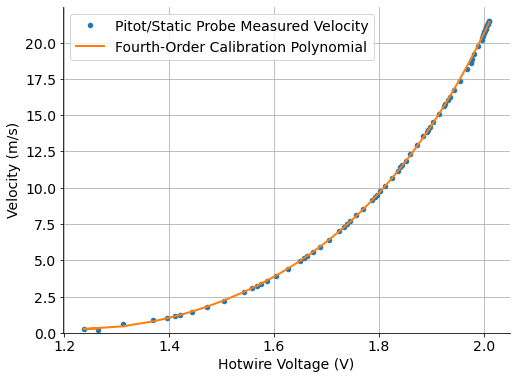

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(EV, UP, '.', markersize=9)
ax.plot(EV, np.polyval(cal_coeff, EV), linewidth=2)
ax.set_xlabel('Hotwire Voltage (V)', fontsize=14)
ax.set_ylabel('Velocity (m/s)', fontsize=14)
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, UP[-1]+1])
ax.legend(['Pitot/Static Probe Measured Velocity', 'Fourth-Order Calibration Polynomial'], fontsize=14)
ax.set_xticks(np.arange(1.2, EV[-1], step=0.2))
ax.set_xticklabels([1.2, 1.4, 1.6, 1.8, 2.0], size = 14)
ax.set_yticks(np.arange(0, 22, step=2.5))
ax.set_yticklabels(np.arange(0, 22, step=2.5), size=14)
fig.savefig('calibration.png')

In [16]:
################################################################
#### Deliverable 3 #############################################
################################################################
VP_X1 = getVelocityProfile('velocity_profile_x1')
VP_X3 = getVelocityProfile('velocity_profile_x3')
VP_X4 = getVelocityProfile('velocity_profile_x4')

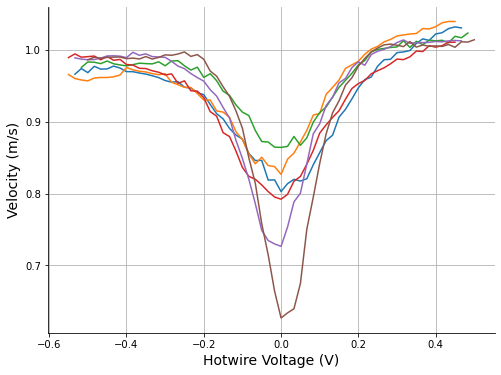

In [21]:
U1H, Y1H = computeInfo(VP_X1, 'HotWireVel')
U3H, Y3H = computeInfo(VP_X3, 'HotWireVel')
U4H, Y4H = computeInfo(VP_X4, 'HotWireVel')
U1P, Y1P = computeInfo(VP_X1, 'PitotVel')
U3P, Y3P = computeInfo(VP_X3, 'PitotVel')
U4P, Y4P = computeInfo(VP_X4, 'PitotVel')
fig, bx = plt.subplots(figsize=(8,6))
bx.plot(Y1H, VP_X1['HotWireVel']/U1H)
bx.plot(Y3H, VP_X3['HotWireVel']/U3H)
bx.plot(Y4H, VP_X4['HotWireVel']/U4H)
bx.plot(Y1P, VP_X1['PitotVel']/U1P)
bx.plot(Y3P, VP_X3['PitotVel']/U3P)
bx.plot(Y4P, VP_X4['PitotVel']/U4P)
bx.set_xlabel('Hotwire Voltage (V)', fontsize=14)
bx.set_ylabel('Velocity (m/s)', fontsize=14)
bx.grid()
bx.spines['top'].set_visible(False)
bx.spines['right'].set_visible(False)

In [25]:
################################################################
#### Deliverable 5 #############################################
################################################################

#### Reynolds number ###########################################
T = 21.5 + 273.15 # K
P = 98.5 * 1000 # Pa
R = 287 # J/kg-K

rho = P/R/T
U_inf = np.array([U1H, U3H, U4H, U1P, U3P, U4P]) # m/s
mu = computeDynViscosity(T)
D = 19.05/1000 # m
w = 300/1000 # m

Re = rho * U_inf * D / mu

#### Drag force ################################################
# Collect velocity profiles
u3 = [VP_X1['HotWireVel'], VP_X3['HotWireVel'], VP_X4['HotWireVel'], 
      VP_X1['PitotVel'], VP_X3['PitotVel'], VP_X4['PitotVel']]
# Discrete y locations
y_ax = np.array(VP_X1['LateralPos'])
# Create list for drag force
F_D = np.zeros(len(U_inf))
# Compute drag force
for idx in range(len(U_inf)):
    F_D[idx] = (computeDragDiscrete(U_inf[idx], np.array(u3[idx]), y_ax, rho, w))

# Compute quantities for nondimensionalization 
q = 0.5 * rho * U_inf**2
A = w * D
# Compute C_D
C_D = F_D / q / A

#### Consolidate and present computations ######################
df3 = pd.DataFrame(np.vstack((Re, F_D, C_D)),
                   columns=['Profile 1 H', 'Profile 3 H', 'Profile 4 H',
                            'Profile 1 P', 'Profile 3 P', 'Profile 4 P'])
df3.insert(0, 'Parameter', ['Re', 'F_D', 'C_D'])
display(df3)

,Parameter,Profile 1 H,Profile 3 H,Profile 4 H,Profile 1 P,Profile 3 P,Profile 4 P
0,Re,23852.104613,22616.382155,24739.029526,22371.187842,22209.891832,22354.530068
1,F_D,917.879823,645.737861,616.416739,824.904693,678.184582,724.544171
2,C_D,720.123580,563.487910,449.555924,735.699235,613.662585,647.155128


FFT_10.xlsx: 96.25
FFT_13.xlsx: 128.59375
FFT_16.xlsx: 159.375
FFT_19.xlsx: 191.71875
FFT_22.xlsx: 213.90625


(0.0, 35000.0)

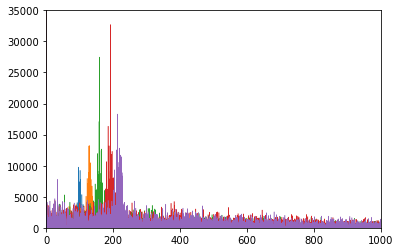

In [19]:
large_FFT_files = ['FFT_10.xlsx', 'FFT_13.xlsx', 'FFT_16.xlsx', 'FFT_19.xlsx', 'FFT_22.xlsx']
peaks = []
for file in large_FFT_files:
    sp, freq, peak = computeFFT(file)
    peaks.append(peak)
    print(file+':', peak)
    plt.plot(freq, sp.real, linewidth=0.5)
plt.xlim((0, 1000))
plt.ylim((0, 35000))

In [9]:
all_files = ''.join(large_FFT_files)
vels = [int(s) for s in re.findall(r'\d+', all_files)]
d = 19.05/1000
St = np.array(peaks) * d / np.array(vels)
print(St)

[0.183 0.188 0.19  0.192 0.185]


In [10]:
# Reynolds number calculation
T = 21.5 + 273.15 # K
P = 98.5 * 1000 # Pa
R = 287 # J/kg-K

rho = P/R/T
V = np.array([10, 13, 16, 19, 22]) # m/s
mu = computeDynViscosity(T)
D = [19.05/1000, 12.07/1000] # m
w = 300/1000 # m

Re_L = rho * V * D[0] / mu
Re_S = rho * V * D[1] / mu
print(Re_L)
print(Re_S)

[12188.615 15845.2   19501.785 23158.369 26814.954]
[ 7722.656 10039.452 12356.249 14673.046 16989.842]
